In [1]:
import pandas as pd
import random
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import yaml
import os
import datetime as dt
import pytz
import math
import scipy
import pickle
import requests
import json
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:

analyser = SentimentIntensityAnalyzer()

In [5]:
## is it really this easy to just get the happiness lexicon from the hedonometer

r = requests.get("http://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v2")

In [6]:
import json

json_data = json.loads(r.text)

In [7]:
# create hedonometer dict
hed_dict = {}

for obj in json_data['objects']:
    hed_dict[obj['word']] = obj

In [ ]:
# random sample of hed_dict
keys = random.sample(list(hed_dict),10)

for k in keys:
    print(k, hed_dict[k])

In [3]:
# clean words are words defined in hednometer lexicon
def get_word_ct(x, dict, tune_delta=None):
    res = []
    for wrd in str(x).split():
        if wrd.lower() in dict.keys():
            if tune_delta:
                if abs(dict[wrd.lower()]['happs'] - 5) > tune_delta:
                    res.append(wrd)
            else:
                res.append(wrd)
                    
    return len(res)
    
# get sum of clean word scores
def get_total_word_score(x, dict, tune_delta=None):
    res = []
    for wrd in str(x).split():
        if wrd.lower() in dict.keys():
            if tune_delta:
                if abs(dict[wrd.lower()]['happs'] - 5) > tune_delta:
                    res.append(dict[wrd.lower()]['happs'])
            else:
                res.append(dict[wrd.lower()]['happs'])
                    
    return sum(res)

def get_hedonometer_word_dict(x, dict,  tune_delta=None):
    res = {'words':{}, 'freq':0}
    for wrd in str(x).split():
        if wrd.lower() in dict.keys():
            if tune_delta:
                if abs(dict[wrd.lower()]['happs'] - 5) > tune_delta:
                    res['words'][wrd] = dict[wrd.lower()]['happs']
                    res['freq'] += 1
            else:
                res['words'][wrd] = dict[wrd.lower()]['happs']
                res['freq'] += 1
                    
    return res


# delta 1
# tweets_df['hedonometer_frequency'] = tweets_df.content.apply(lambda x: get_word_ct(x, hed_dict,1))
# tweets_df['hedonometer_total_score'] = tweets_df.content.apply(lambda x: get_total_word_score(x, hed_dict,1))
# tweets_df['hedonometer_score'] = tweets_df.hedonometer_total_score/tweets_df.hedonometer_frequency
# tweets_df['hedonometer_dict'] = tweets_df.content.apply(lambda x: get_hedonometer_word_dict(x, hed_dict, 1))

# tweets_df.iloc[random.sample(range(100),1)]

[great guide for using python requests and twitter api](https://benalexkeen.com/interacting-with-the-twitter-api-using-python/)

In [ ]:
# api creds
creds = yaml.load(
    open(os.path.expanduser('~/.twitter/creds.yml')), 
    Loader=yaml.FullLoader)

client_key = creds['api-key']
client_secret = creds['api-secret']

import base64

key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')

In [ ]:
import requests

base_url = 'https://api.twitter.com/'
auth_url = '{}oauth2/token'.format(base_url)

auth_headers = {
    'Authorization': 'Basic {}'.format(b64_encoded_key),
    'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
}

auth_data = {
    'grant_type': 'client_credentials'
}

In [ ]:
auth_resp = requests.post(auth_url, headers=auth_headers, data=auth_data)

In [ ]:
access_token = auth_resp.json()['access_token']

In [ ]:
# # v 2 api
# # 225 requests per 15-minute window, 1 request every 2 seconds
# end_time = str((dt.datetime.utcnow() - dt.timedelta(minutes=30)).isoformat()) + 'Z'
# start_time = str((dt.datetime.utcnow() - dt.timedelta(days=1, minutes=30)).isoformat()) + 'Z'



# search_headers = {
#     'Authorization': 'Bearer {}'.format(access_token)    
# }

# search_params = {
#     'query': 'entity: United States -is:retweet',
#     'max_results': 100, 
#     'end_time': end_time,
#     'start_time': start_time,
#     'tweet.fields': 'created_at,lang',
#     'user.fields': 'username,description',
#     'place.fields': 'country,geo',
    
# }

# search_url = '{}2/tweets/search/recent'.format(base_url)

# search_resp = requests.get(search_url, headers=search_headers, params=search_params)
# tweet_data = search_resp.json()
# print(tweet_data.keys())
# print(len(tweet_data['data']))

# # random sample of tweets
# for obj in random.sample(tweet_data['data'],10):
#     print(str(obj) + '\n')


In [ ]:
### let's get a bunch of tweets for the trailing 5 days
# bewary of 450 per 15 limit
import time

tweets = []
for i in range(24*5*2):
    end_time = str((dt.datetime.utcnow() - dt.timedelta(minutes=30 + 30 * i)).isoformat()) + 'Z'
    start_time = str((dt.datetime.utcnow() - dt.timedelta(minutes=30 + 30 * (i + 1))).isoformat()) + 'Z'



    search_headers = {
        'Authorization': 'Bearer {}'.format(access_token)    
    }

    search_params = {
        'query': 'entity: United States -is:retweet',
        'max_results': 100, 
        'end_time': end_time,
        'start_time': start_time,
        'tweet.fields': 'created_at,lang',
        'user.fields': 'username,description',
        'place.fields': 'country,geo',

    }

    search_url = '{}2/tweets/search/recent'.format(base_url)

    search_resp = requests.get(search_url, headers=search_headers, params=search_params)
#     print(search_resp.text)
    tweet_data = json.loads(search_resp.text)
    
    if 'data' in tweet_data.keys():
        print(dt.datetime.utcnow(), start_time, end_time, len(tweet_data['data']))
        tweets = tweets + tweet_data['data']

    

In [ ]:
tweet_data.keys()

In [ ]:
print(len(tweets))
tweets[0]

In [ ]:
tdf = pd.DataFrame(data=tweets)

In [ ]:
tdf['hedonometer_frequency'] = tdf.text.apply(lambda x: get_word_ct(x, hed_dict,1))
tdf['hedonometer_total_score'] = tdf.text.apply(lambda x: get_total_word_score(x, hed_dict,1))
tdf['hedonometer_score'] = tdf.hedonometer_total_score/tdf.hedonometer_frequency

tdf['vader_score'] = tdf.text.apply(lambda x: analyser.polarity_scores(x)['compound'])

tdf['hedonometer_score_normalized'] = (tdf.hedonometer_score - tdf.hedonometer_score.mean())/tdf.hedonometer_score.std()
tdf['vader_score_normalized'] = (tdf.vader_score - tdf.vader_score.mean())/tdf.vader_score.std()

tdf['hedonometer_dict'] = tdf.text.apply(lambda x: get_hedonometer_word_dict(x, hed_dict, 1))

tdf['score_delta'] = abs(tdf.hedonometer_score_normalized - tdf.vader_score_normalized)

In [ ]:
tdf['datetime'] = pd.to_datetime(tdf.created_at)

In [ ]:
for ix in tdf[tdf.hedonometer_score_normalized>0].sort_values(by='score_delta', ascending=False).head(10).index.values:
    print(
        tdf.text.iloc[ix], 
        tdf.hedonometer_score_normalized.iloc[ix], 
        tdf.vader_score_normalized.iloc[ix],
        tdf.hedonometer_score.iloc[ix],
        tdf.hedonometer_dict[ix]
    )

In [99]:
### getting overall happiness from hedonometer
uri = 'http://hedonometer.org/api/v1/happiness/?format=json&timeseries__title=en_all&date__gte=2010-01-01'
r = requests.get(uri)
hed_df = pd.DataFrame(json.loads(r.content)['objects'])
hed_df.sort_values('date', inplace=True)
hed_df['datetime'] = pd.to_datetime(hed_df.date)

hed_df.tail()

,date,frequency,happiness,timeseries,datetime
4011,2020-12-25,146266113.0,6.224,/api/v1/timeseries/3/,2020-12-25
4012,2020-12-26,162456583.0,6.019,/api/v1/timeseries/3/,2020-12-26
4013,2020-12-27,172248751.0,5.967,/api/v1/timeseries/3/,2020-12-27
4014,2020-12-28,179229530.0,5.941,/api/v1/timeseries/3/,2020-12-28
4015,2020-12-29,188607879.0,5.957,/api/v1/timeseries/3/,2020-12-29


In [ ]:
hed_df[pd.to_datetime(hed_df.date).dt.year==2020].happiness.astype(float).describe()

In [100]:
### getting overall happiness from hedonometer
uri = 'http://hedonometer.org/api/v1/events/?format=json&happs__timeseries__title=en_all&happs__date__gte=2010-05-15'
r = requests.get(uri)
hed_df2 = pd.DataFrame(json.loads(r.content)['objects'])
hed_df2['datetime'] = pd.to_datetime(hed_df2.happs.apply(lambda x: x['date']))
hed_df2['happiness'] = hed_df2.happs.apply(lambda x: x['happiness'])
hed_df2.sort_values('datetime', inplace=True)
hed_df2['datetime'] = pd.to_datetime(hed_df.datetime)

hed_df2.tail(1).T.to_dict()

{221: {'happs': {'date': '2020-11-26',
   'frequency': 168735338.0,
   'happiness': '6.059',
   'timeseries': '/api/v1/timeseries/3/'},
  'id': 744,
  'importance': -30,
  'longer': 'Thanksgiving, United States',
  'resource_uri': '/api/v1/events/744/',
  'shorter': 'Thanksgiving, United States',
  'wiki': 'http://en.wikipedia.org/wiki/Thanksgiving',
  'x': 30,
  'y': -50,
  'datetime': Timestamp('2010-07-20 00:00:00'),
  'happiness': '6.059'}}

In [ ]:
### getting all my text messages
import sqlite3
import os

# substitute username with your username
conn = sqlite3.connect(os.path.expanduser('~/Library/Messages/chat.db'))

messages = pd.read_sql_query("select *, datetime(date/1000000000 + 978307200,'unixepoch','localtime') as datetime_str from message order by date", conn)

messages_df = messages[messages.text != '￼'].reset_index(drop=True)
messages_df['datetime'] = pd.to_datetime(messages_df.datetime_str)

In [ ]:
messages_df.shape

In [ ]:
# let's score my messages
analyser = SentimentIntensityAnalyzer()

def get_vader_compound_score(x):
    try: 
        vader_result = analyser.polarity_scores(x)
        return vader_result['compound']
    except (ValueError, TypeError):
        return None
        


messages_df['hedonometer_frequency'] = messages_df.text.apply(lambda x: get_word_ct(x, hed_dict,1))
messages_df['hedonometer_total_score'] = messages_df.text.apply(lambda x: get_total_word_score(x, hed_dict,1))
messages_df['hedonometer_score'] = messages_df.hedonometer_total_score/messages_df.hedonometer_frequency
messages_df['hedonometer_dict'] = messages_df.text.apply(lambda x: get_hedonometer_word_dict(x, hed_dict, 1))

# messages_df['vader_score'] = messages_df.text.apply(lambda x: analyser.polarity_scores(x))
messages_df['compound_score'] = messages_df.text.apply(lambda x: get_vader_compound_score(x))

messages_df['compound_score_normalized'] = (messages_df.compound_score - messages_df.compound_score.mean())/messages_df.compound_score.std()
messages_df['hedonometer_score_normalized'] = (messages_df.hedonometer_score - messages_df.hedonometer_score.mean())/messages_df.hedonometer_score.std()

In [ ]:
messages_df[~messages_df.compound_score.isna()].shape

In [ ]:
type(messages_df.datetime.iloc[0])

In [ ]:
gdf = messages_df[~messages_df.compound_score.isna()].groupby(messages_df.datetime.dt.date).agg(
    {
        'compound_score_normalized': 'mean',
        'hedonometer_score_normalized': 'mean', 
        'hedonometer_score': 'mean'
    }
)

# hedonommeter score dict
hed_score_dict = hed_df.set_index(hed_df.datetime.dt.date).T.to_dict()

# add scores
gdf['date'] = gdf.index.values
gdf['hedonometer_score_10d'] = gdf.hedonometer_score.rolling(window=10, min_periods=10).mean()
gdf['global_hedonometer_score'] = gdf.date.apply(lambda x: hed_score_dict[x]['happiness'] if x in hed_score_dict.keys() else None)
gdf['global_hedonometer_score_10d'] = gdf.global_hedonometer_score.rolling(window=10, min_periods=10).mean()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.hedonometer_score_normalized
    , name='Hedonometer Delta 1'
   , line=dict(color='firebrick', width=1))
)


fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.compound_score_normalized
    , name='Vader Adj'
   , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='My Text Message Happiness',
                   xaxis_title='Date',
                   yaxis_title='Adj. Score')

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.hedonometer_score_10d
    , name='My Hedonometer'
   , line=dict(color='firebrick', width=1))
)


fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.global_hedonometer_score_10d
    , name='Global Hedonometer'
   , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='My Texts and Global Happiness Rolling 10d Avg',
                   xaxis_title='Date',
                   yaxis_title='Adj. Score')

fig.show()

In [ ]:
# let's get november articles going all the way back to 185

# if os.path.exists('./nyt_data_hist.pkl'):
#     with open('nyt_data_hist.pkl', 'rb') as f:
#         nyt_data = pickle.load(f)
# else:

# get creds
nyt_creds = yaml.load(open(os.path.expanduser('~/.nyt/creds.yml'),'r'), Loader=yaml.FullLoader)

nyt_url = "https://api.nytimes.com/svc/archive/v1/{year}/{month_num}.json"
# print(nyt_url.format(**{'year': '2020', 'month_num':1}))
params = {
    'api-key': nyt_creds['api-key']
}

### let's get all the news
#     nyt_data = []
start_time = dt.datetime.now()

for y in range(1920, 2021):
    for m in range(1,13):
        month_num = m
        year_num = y

        fname = f'nyt-archive-{m}-{y}.json'
        

        r = requests.get(
            url = nyt_url.format(**{'year': year_num, 'month_num': month_num})
            , params = params
        ) 

        response_json = json.loads(r.text)
        if 'response' in response_json.keys():
            if 'docs' in response_json['response'].keys():

                # if docs in json response, write json response to file
                
                with open(fname, 'w', encoding='utf-8') as f:
                    json.dump(response_json['response']['docs'], f, ensure_ascii=False, indent=4)


                    #                     nyt_data = nyt_data + response_json['response']['docs']

        print(response_json.keys(), month_num, year_num)

        if 'fault' in response_json.keys():
                print(response_json['fault'])

        # no more than 10 calls per minutes and responses seem to be taking 5-10 secs
        time.sleep(3)


total_time = (dt.datetime.now() - start_time).seconds

print(f'total time secs = {total_time}')

# pickle responses

#     with open('nyt_data_hist.pkl', 'wb') as f:
#         pickle.dump(nyt_data, f)
    

In [58]:
gdf = pd.DataFrame()

for y in range(1920, 2021):
    for m in range(1,13):
        month_num = m
        year_num = y
        
        fname = f'./nyt-archive-{m}-{y}.json'
        
        with open(fname,'r') as f:
            nyt_hist_data = json.load(f)
            
            df = pd.DataFrame(data=nyt_hist_data)
            # only front page and has abstract
            if 'abstract' in df.columns.values and 'print_page' in df.columns.values:
                df = df[
                    (df.print_page=='1')
                    & (df.abstract != '')
                ].reset_index(drop=True)

                # calc some fields 
                df['published_datetime'] = pd.to_datetime(df.pub_date)
                # headlines
                df['hedonometer_frequency'] = df.headline.apply(lambda x: get_word_ct(x['main'], hed_dict,1))
                df['hedonometer_total_score'] = df.headline.apply(lambda x: get_total_word_score(x['main'], hed_dict,1))
                df['hedonometer_score'] = df.hedonometer_total_score/df.hedonometer_frequency
                df['hedonometer_dict'] = df.headline.apply(lambda x: get_hedonometer_word_dict(x['main'], hed_dict, 1))

                # lead paragraphs
                df['hedonometer_frequency_abstract'] = df.abstract.apply(lambda x: get_word_ct(x, hed_dict,1))
                df['hedonometer_total_score_abstract'] = df.abstract.apply(lambda x: get_total_word_score(x, hed_dict,1))
                df['hedonometer_score_abstract'] = df.hedonometer_total_score_abstract/df.hedonometer_frequency_abstract
                df['hedonometer_dict_abstract'] = df.abstract.apply(lambda x: get_hedonometer_word_dict(x, hed_dict, 1))
                
                df['total_words'] = df.headline.apply(lambda x: len(x['main'].split(' ')))
                df['total_words_abstract'] = df.abstract.apply(lambda x: len(x.split(' ')))


                grouped_df = df.groupby(df.published_datetime.apply(lambda x: dt.date(x.year, x.month, 1))).agg(
                    {
                        'hedonometer_score': 'mean',
                        'hedonometer_score_abstract': 'mean',
                        'abstract': 'count',
                        'total_words': 'sum', 
                        'total_words_abstract': 'sum',
                    }
                )
                
                grouped_df['published_month'] = grouped_df.index.values
                
                gdf = gdf.append(grouped_df).sort_values(by='published_month')


# # pickle responses
# with open('nyt_data_hist.pkl', 'wb') as f:
#     pickle.dump(nyt_hist_data, f)

In [63]:
print(gdf.total_words.sum()/1e6, gdf.total_words_abstract.sum()/1e6)
gdf.describe()

10.563041 34.556462


,hedonometer_score,hedonometer_score_abstract,abstract,total_words,total_words_abstract
count,1215.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,5.580166,5.727612,575.340461,8686.711349,28418.143092
std,0.170014,0.172685,201.721376,4436.465760,27450.567807
min,3.204286,2.850000,1.000000,9.000000,7.000000
25%,5.505655,5.620977,450.000000,4804.750000,10394.750000
50%,5.607247,5.736196,521.000000,8686.500000,14250.000000
75%,5.679460,5.837500,679.000000,11515.250000,36384.750000
max,6.563333,6.321667,1770.000000,23124.000000,118465.000000


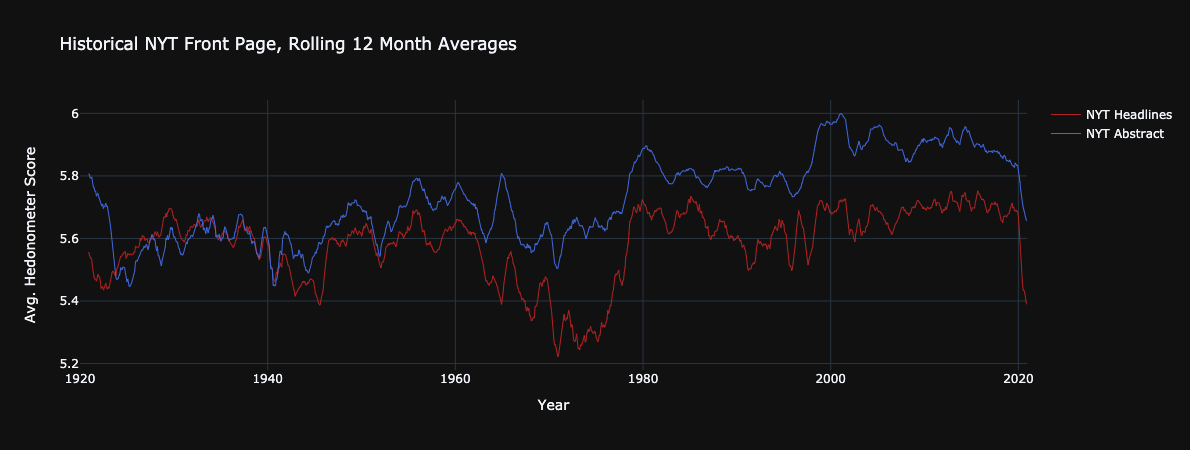

In [87]:
plot_df = gdf.loc[gdf.index.values>=dt.date(1920,1,1)]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=plot_df.index.values
    , y=plot_df.hedonometer_score.rolling(window=12).mean()
    , name='NYT Headlines'
   , line=dict(color='firebrick', width=1))
)

fig.add_trace(go.Scatter(
    x=plot_df.index.values
    , y=plot_df.hedonometer_score_abstract.rolling(window=12).mean()
    , name='NYT Abstract'
   , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='Historical NYT Front Page, Rolling 12 Month Averages'
                  , xaxis_title='Year',
                  yaxis_title='Avg. Hedonometer Score', 
#                   xaxis_range=[dt.date(1920,1,1), dt.date(2020,12,31)],
#                   yaxis_range=[4.5,6.5]
                   
                 )

# dark theme 
fig.layout.template = 'plotly_dark'

# save file to html
fig.write_json(os.path.abspath('../../personal-site/static/plotly/hedonometer/nyt-hist-headlines.json'))

fig.show()


In [111]:
m = 1
y = 2008

fname = f'./nyt-archive-{m}-{y}.json'

with open(fname,'r') as f:
    nyt_hist_data = json.load(f)
    df = pd.DataFrame(data=nyt_hist_data)
    # only front page and has abstract
    if 'abstract' in df.columns.values and 'print_page' in df.columns.values:
        df = df[
            (df.print_page=='1')
            & (df.abstract != '') 
            & (df.abstract.apply(lambda x: len(x.split(' ')))>=10) # abstracts with more than 10 words
        ].reset_index(drop=True)

sample_df = df.sample(3)
for h, a in zip(sample_df.headline.apply(lambda x: x['main']), sample_df.abstract):
    print(f'>{h}\n {a}\n \n')

>Justices Chilly to Bid to Alter Death Penalty
 An effort to change the way states carry out executions by lethal injection appeared to founder before the Supreme Court.
 

>To Some, the Widening Crisis Seems Driven by Fear, Not Facts
 What makes the current correction dangerous, analysts say, is that selling is being driven by hedge funds and investment banks, not panicky retail investors.
 

>4 Named in Shooting of Fellow Officer
 Authorities in Westchester County released the names and photographs of the county police officers involved in the shooting death of an off-duty officer from the city of Mount Vernon.
 



In [77]:
### NY Times; current data
if os.path.exists('./nyt_data.pkl'):
    with open('nyt_data.pkl', 'rb') as f:
        nyt_data = pickle.load(f)
else:

    # get creds
    nyt_creds = yaml.load(open(os.path.expanduser('~/.nyt/creds.yml'),'r'), Loader=yaml.FullLoader)

    nyt_url = "https://api.nytimes.com/svc/archive/v1/{year}/{month_num}.json"
    # print(nyt_url.format(**{'year': '2020', 'month_num':1}))
    params = {
        'api-key': nyt_creds['api-key']
    }

    ### let's get all the news
    nyt_data = []

    total_months = math.ceil((dt.datetime.today() - dt.datetime(2010,1,1)).days/30)
    start_time = dt.datetime.now()
    for i in range(total_months):
        month_num = (dt.datetime.today() - dt.timedelta(days=30*i)).month
        year_num = (dt.datetime.today() - dt.timedelta(days=30*i)).year

        r = requests.get(
            url = nyt_url.format(**{'year': year_num, 'month_num': month_num})
            , params = params
        ) 

        response_json = json.loads(r.text)
        if 'response' in response_json.keys():
            if 'docs' in response_json['response'].keys():
                nyt_data = nyt_data + response_json['response']['docs']

        print(response_json.keys(), month_num, year_num)

        if 'fault' in response_json.keys():
                print(response_json['fault'])

        # no more than 10 calls per minutes and responses seem to be taking 5-10 secs
        time.sleep(3)


    total_time = (dt.datetime.now() - start_time).seconds

    print(f'total time secs = {total_time}')
    
    # pickle responses
    
    with open('nyt_data.pkl', 'wb') as f:
        pickle.dump(nyt_data, f)

In [96]:
nyt_df = pd.DataFrame(data=nyt_data)
nyt_df.shape

(880138, 20)

In [97]:
# calc some fields 
nyt_df['published_datetime'] = pd.to_datetime(nyt_df.pub_date)

# headlines
nyt_df['hedonometer_frequency'] = nyt_df.headline.apply(lambda x: get_word_ct(x['main'], hed_dict,1))
nyt_df['hedonometer_total_score'] = nyt_df.headline.apply(lambda x: get_total_word_score(x['main'], hed_dict,1))
nyt_df['hedonometer_score'] = nyt_df.hedonometer_total_score/nyt_df.hedonometer_frequency
nyt_df['hedonometer_dict'] = nyt_df.headline.apply(lambda x: get_hedonometer_word_dict(x['main'], hed_dict, 1))

# lead paragraphs
nyt_df['hedonometer_frequency_abstract'] = nyt_df.abstract.apply(lambda x: get_word_ct(x, hed_dict,1))
nyt_df['hedonometer_total_score_abstract'] = nyt_df.abstract.apply(lambda x: get_total_word_score(x, hed_dict,1))
nyt_df['hedonometer_score_abstract'] = nyt_df.hedonometer_total_score_abstract/nyt_df.hedonometer_frequency_abstract
nyt_df['hedonometer_dict_abstract'] = nyt_df.abstract.apply(lambda x: get_hedonometer_word_dict(x, hed_dict, 1))

# messages_df['vader_score'] = messages_df.text.apply(lambda x: analyser.polarity_scores(x))
# nyt_df['compound_score'] = nyt_df.headline.apply(lambda x: get_vader_compound_score(x['main']))
# nyt_df['compound_score_lp'] = nyt_df.lead_paragraph.apply(lambda x: get_vader_compound_score(x))

In [102]:
nyt_by_day = nyt_df[
    (nyt_df.print_page=='1')
    & (nyt_df.abstract != '')
].groupby(nyt_df.published_datetime.dt.date).agg(
    {
        'hedonometer_score': 'mean', 
        'hedonometer_score_abstract': 'mean', 
    }
)

# hedonommeter score dict
hed_score_dict = hed_df.set_index(hed_df.datetime.dt.date).T.to_dict()
hed_event_dict = hed_df2.set_index(hed_df2.datetime.dt.date).T.to_dict()

# add scores
nyt_by_day['date'] = nyt_by_day.index.values
nyt_by_day['global_hedonometer_score'] = nyt_by_day.date.apply(lambda x: hed_score_dict[x]['happiness'] if x in hed_score_dict.keys() else None)
nyt_by_day['global_hedonometer_event_shorter'] = nyt_by_day.date.apply(lambda x: hed_event_dict[x]['shorter'] if x in hed_event_dict.keys() else None)

nyt_by_day['hedonometer_score_30d'] = nyt_by_day.hedonometer_score.rolling(window=30, min_periods=30).mean()
nyt_by_day['hedonometer_score_abstract_30d'] = nyt_by_day.hedonometer_score_abstract.rolling(window=30, min_periods=30).mean()
nyt_by_day['global_hedonometer_score_30d'] = nyt_by_day.global_hedonometer_score.rolling(window=30, min_periods=30).mean()

In [ ]:
nyt_by_day.head(10)

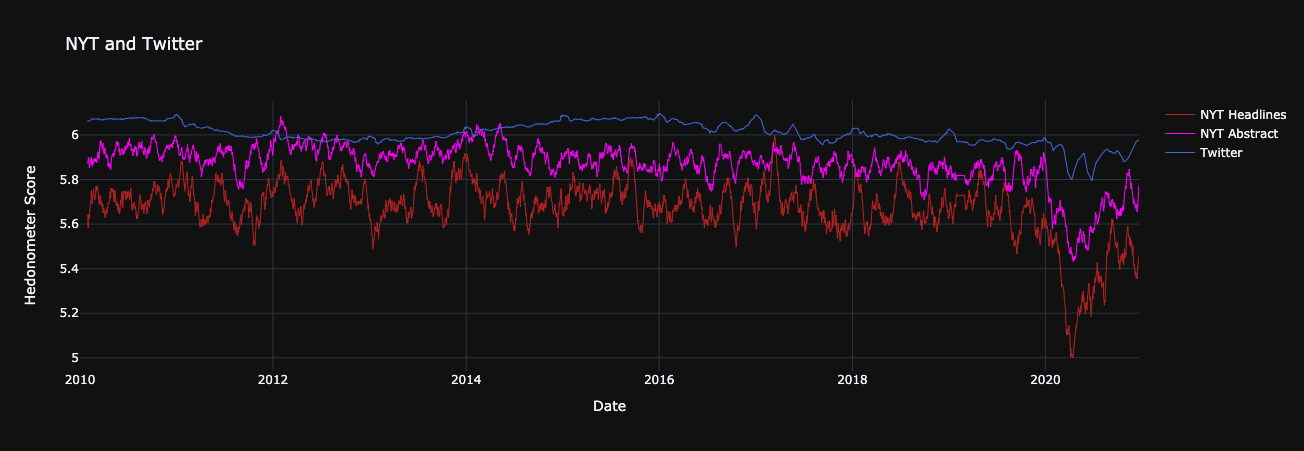

In [105]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=nyt_by_day.index.values
    , y=nyt_by_day.hedonometer_score_30d
    , name='NYT Headlines'
   , line=dict(color='firebrick', width=1))
)

fig.add_trace(go.Scatter(
    x=nyt_by_day.index.values
    , y=nyt_by_day.hedonometer_score_abstract_30d
    , name='NYT Abstract'
   , line=dict(color='magenta', width=1))
)

fig.add_trace(go.Scatter(
    x=nyt_by_day.index.values
    , y=nyt_by_day.global_hedonometer_score_30d
    , name='Twitter'
    , line=dict(color='royalblue', width=1))
)

# set x axis
fig.update_xaxes(range=[dt.date(2010,1,1),dt.date(2020,12,20)])

# Edit the layout
fig.update_layout(title='NYT and Twitter',
                   xaxis_title='Date',
                   yaxis_title='Hedonometer Score')

# dark theme 
fig.layout.template = 'plotly_dark'

# save file to html
fig.write_json(os.path.abspath('../../personal-site/static/plotly/hedonometer/nyt-twitter-rolling-avg.json'))

fig.show()

In [ ]:
## worst day
nyt_df[
    (nyt_df.published_datetime.dt.date == dt.date(2020,4,15))
].sort_values('hedonometer_score_lp', ascending=True)[['headline'
                                                    ,'hedonometer_score'
                                                    ,'hedonometer_dict'
                                                    , 'lead_paragraph'
                                                    , 'hedonometer_score_lp'
                                                    ,'hedonometer_dict_lp',
                                                   ]].head(3).T.to_dict()

In [ ]:
## best day
nyt_df[
    (nyt_df.published_datetime.dt.date == dt.date(2019,6,21))
].sort_values('hedonometer_score_lp', ascending=False)[['headline'
                                                    ,'hedonometer_score'
                                                    ,'hedonometer_dict'
                                                    , 'lead_paragraph'
                                                    , 'hedonometer_score_lp'
                                                    ,'hedonometer_dict_lp',
                                                   ]].head(3).T.to_dict()

### Ideas
- remove corona virus articles
- sections of article

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=nyt_by_day.index.values
    , y=nyt_by_day.compound_score_30d
    , name='NYT Headliness'
   , line=dict(color='firebrick', width=1))
)

fig.add_trace(go.Scatter(
    x=nyt_by_day.index.values
    , y=nyt_by_day.compound_score_lp_30d
    , name='NYT Lead Paragraph'
   , line=dict(color='magenta', width=1))
)

# set x axis
fig.update_xaxes(range=[dt.date(2010,1,1),dt.date(2020,12,20)])

# Edit the layout
fig.update_layout(title='NYT Vader Score',
                   xaxis_title='Date',
                   yaxis_title='Hedonometer Score')

fig.show()

In [ ]:
nyt_df.iloc[1200].T.to_dict()

In [ ]:
section_df = nyt_df.groupby(['section_name','subsection_name']).agg(
    {
        'headline': 'count'
        , 'hedonometer_score_lp': 'mean'
        , 'compound_score_lp': 'mean'
    }
).sort_values(by='headline', ascending=False).head(20)

In [ ]:
section_df.sort_values(by='headline', ascending=False)

In [ ]:
section_df.sort_values(by='hedonometer_score_lp')

In [ ]:
# section by day for specific nytimes subsections
section_by_day_df = nyt_df[nyt_df.subsection_name.isin([
    'Politics', 'Asia Pacific', 'Europe', 'Middle East', 'Book Review', 'Music', 'Weddings'
    ]
)].groupby([nyt_df.published_datetime.dt.date, nyt_df.subsection_name]).agg(
    {
        'compound_score_lp': 'mean',
        'hedonometer_score_lp': 'mean', 
    }
)

# hedonommeter score dict
hed_score_dict = hed_df.set_index(hed_df.datetime.dt.date).T.to_dict()

# add scores
section_by_day_df['date'] = section_by_day_df.index.get_level_values(0)
section_by_day_df['subsection'] = section_by_day_df.index.get_level_values(1)

# nyt_by_day['compound_score_30d'] = nyt_by_day.compound_score.rolling(window=30, min_periods=30).mean()
# nyt_by_day['compound_score_lp_30d'] = nyt_by_day.compound_score_lp.rolling(window=30, min_periods=30).mean()
# nyt_by_day['hedonometer_score_30d'] = nyt_by_day.hedonometer_score.rolling(window=30, min_periods=30).mean()
# section_by_day_df['hedonometer_score_lp_30d'] = section_by_day_df.hedonometer_score_lp.rolling(window=30, min_periods=30).mean()
# nyt_by_day['global_hedonometer_score_30d'] = nyt_by_day.global_hedonometer_score.rolling(window=30, min_periods=30).mean()
    
section_by_day_df.tail()

In [ ]:
section_by_day_df.index

In [ ]:
section_by_day_df.xs('Politics', level=1).head()

In [ ]:
section_by_day_df.index.get_level_values(1).unique().values

In [ ]:
fig = go.Figure()

for sect in section_by_day_df.index.get_level_values(1).unique().values:
    
    df = section_by_day_df.xs(sect, level=1)
    df['hedonometer_score_lp_30d'] = df.hedonometer_score_lp.rolling(window=30, min_periods=30).mean()

    fig.add_trace(go.Scatter(
         x=df.index.values
        , y=df.hedonometer_score_lp_30d
        , name=sect
    #    , line=dict(color='firebrick', width=1))
    ))

# Edit the layout
fig.update_layout(title='NYT Section Lead Paragraphs',
                   xaxis_title='Date',
                   yaxis_title='Hedonometer Score')

fig.show()

In [ ]:
df = nyt_df[(nyt_df.subsection_name=='Politics')  & (nyt_df.published_datetime.dt.date==dt.date(2020,6,1))]

for lp in df.lead_paragraph.sample(3).values:
    
    print(lp + '\n')

In [ ]:
df = nyt_df[(nyt_df.subsection_name=='Politics')  & (nyt_df.published_datetime.dt.date==dt.date(2010,6,1))]

for lp in df.lead_paragraph.sample(3).values:
    
    print(lp + '\n')

In [ ]:
df = nyt_df[(nyt_df.subsection_name=='Asia Pacific')  & (nyt_df.published_datetime.dt.date==dt.date(2020,6,1))]

for lp in df.lead_paragraph.sample(3).values:
    
    print(lp + '\n')

In [ ]:
df = nyt_df[(nyt_df.subsection_name=='Asia Pacific')  & (nyt_df.published_datetime.dt.date==dt.date(2010,6,1))]

for lp in df.lead_paragraph.sample(3).values:
    
    print(lp + '\n')

In [ ]:
df = nyt_df[(nyt_df.subsection_name=='Politics') & (nyt_df.published_datetime.dt.year==2020)]

word_dict = {}

for d in df.hedonometer_dict_lp.values:
    for k, v in d['words'].items():
#         print(k,v)
        if k not in word_dict.keys():
            word_dict[k] = {}
            word_dict[k]['count'] = 1
            word_dict[k]['score'] = d['words'][k]
        else:
            word_dict[k]['count'] += 1

df=pd.DataFrame(data=word_dict).T

df.sort_values(by='count', ascending=False).head(25)

In [ ]:
df = nyt_df[(nyt_df.subsection_name=='Politics') & (nyt_df.published_datetime.dt.year==2010)]

word_dict = {}

for d in df.hedonometer_dict_lp.values:
    for k, v in d['words'].items():
#         print(k,v)
        if k not in word_dict.keys():
            word_dict[k] = {}
            word_dict[k]['count'] = 1
            word_dict[k]['score'] = d['words'][k]
        else:
            word_dict[k]['count'] += 1

df=pd.DataFrame(data=word_dict).T

df.sort_values(by='count', ascending=False).head(25)

In [ ]:
import ndjson

with open(os.path.abspath('../../data/realdonaldtrump.ndjson')) as f:
    for line in f:
        trump_data = ndjson.load(f)

In [ ]:
trump_df = pd.DataFrame(data=trump_data)

In [ ]:
# calc some stuff
trump_df['datetime'] = pd.to_datetime(trump_df.created_at)

# hedonometer
trump_df['hedonometer_frequency'] = trump_df.text.apply(lambda x: get_word_ct(x, hed_dict,1))
trump_df['hedonometer_total_score'] = trump_df.text.apply(lambda x: get_total_word_score(x, hed_dict,1))
trump_df['hedonometer_score'] = trump_df.hedonometer_total_score/trump_df.hedonometer_frequency
trump_df['hedonometer_dict'] = trump_df.text.apply(lambda x: get_hedonometer_word_dict(x, hed_dict,1))

# vader
trump_df['compound_score'] = trump_df.text.apply(lambda x: get_vader_compound_score(x))

# normalized scores
trump_df['compound_score_normalized'] = (trump_df.compound_score - trump_df.compound_score.mean())/trump_df.compound_score.std()
trump_df['hedonometer_score_normalized'] = (trump_df.hedonometer_score - trump_df.hedonometer_score.mean())/trump_df.hedonometer_score.std()


In [ ]:
print(trump_df.datetime.min(), trump_df.datetime.max())
print(trump_df.shape)
print(trump_df[['hedonometer_score', 'compound_score', 'hedonometer_frequency']].describe())

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(x=trump_df.hedonometer_score, nbinsx=50, name='Hedonometer')
)

# Edit the layout
fig.update_layout(title='Trump Tweets',
                   xaxis_title='Hedonometer'
                 )

fig.layout.template='plotly_dark'


fig.write_json(os.path.abspath('../../personal-site/static/plotly/hedonometer/djt-tweet-hist.json'))
fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(x=trump_df.hedonometer_score_normalized, nbinsx=100, name='Hedonometer')
)

fig.add_trace(
    go.Histogram(x=trump_df.compound_score_normalized, nbinsx=100, name='Vader')
)

# Edit the layout
fig.update_layout(title='Trump Tweets',
                   xaxis_title='Hedonometer'
                 )

fig.layout.template='plotly_dark'

fig.show()

In [ ]:
gdf = trump_df.groupby(trump_df.datetime.apply(lambda x: dt.date(x.year, x.month, 1))).agg(
    {
        'hedonometer_score_normalized': 'mean',
        'compound_score_normalized': 'mean',
    }
)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.hedonometer_score_normalized
    , name='Hedonometer'
   , line=dict(color='firebrick', width=1))
)


fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.compound_score_normalized
    , name='Vader'
   , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='Trump Tweets By Month',
                   xaxis_title='Date',
                   yaxis_title='Scores')

fig.layout.template='plotly_dark'

fig.write_json(os.path.abspath('../../personal-site/static/plotly/hedonometer/djt-tweets-by-month.json'))
fig.show()

In [ ]:
trump_df['retweet_flag']=trump_df.text.apply(lambda x: 1 if x[:2]=='RT' else 0)

In [ ]:
df = trump_df[(trump_df.datetime.dt.date>=dt.date(2016,11,8)) & (trump_df.retweet_flag==0)].reset_index(drop=True)

gdf = df.groupby(df.datetime.apply(lambda x: x.astimezone(pytz.timezone('US/Eastern'))).dt.hour).agg(
    {
        'hedonometer_score_normalized': 'mean',
        'compound_score_normalized': 'mean',
        'text': 'count',
    }
)
# n days
n_days = len(df.datetime.dt.date.unique())

# fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.hedonometer_score_normalized
    , name='Hedonometer'
   , line=dict(color='firebrick', width=1))
)


fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.compound_score_normalized
    , name='Vader'
   , line=dict(color='royalblue', width=1))
)

fig.add_trace(
    go.Bar(
        x=gdf.index.values
        , y=gdf.text
        , name='Tweets'
        , opacity=0.5
    ),
    secondary_y=True,
)

# Edit the layout
fig.update_layout(title='Trump Tweets By Hour, 2016 Election Day to July 2019',
                   xaxis_title='Hour (EST)',
                   yaxis_title='Scores')

# remove secondary yaxis gridlines
fig.layout.yaxis2.showgrid = False
fig.layout.template='plotly_dark'

fig.write_json(os.path.abspath('../../personal-site/static/plotly/hedonometer/djt-tweets-by-hour.json'))

fig.show()

In [ ]:
df = trump_df[trump_df.datetime.dt.date>=dt.date(2016,11,8)].reset_index(drop=True)

for arr in df[df.datetime.apply(lambda x: x.astimezone(pytz.timezone('US/Eastern'))).dt.hour==6][
    [
        'text'
        , 'hedonometer_score'
        , 'compound_score'
        , 'hedonometer_dict'
    ]
].sample(5, random_state=7).values:
    text = arr[0]
    hedonometer_score = arr[1]
    vader_score = arr[2]
    hedonometer_dict = arr[3]
    
    pstr = f"Tweet: {text}\n Hedonometer Score: {hedonometer_score}\n Hedonometer Dict: {hedonometer_dict}\n Vader Score: {vader_score}\n"
    print(pstr)
    

In [ ]:
fig = px.scatter_matrix(
    data_frame=trump_df,
    dimensions=['hedonometer_score_normalized','compound_score_normalized'],
    labels={'hedonometer_score_normalized':'Hedonometer', 'compound_score_normalized':'Vader'}
)

fig.layout.template='plotly_dark'
fig.layout.title='RealDonalTrump Hedonometer and vaderSentiment Corr'
# fig.layout.yaxis.range = [-4,4]

# save figure
fig.write_json(os.path.abspath('../../personal-site/static/plotly/hedonometer/djt-corr.json'))
fig.show()

In [ ]:
import scipy.stats

df = trump_df[(~trump_df.compound_score.isna()) & (~trump_df.hedonometer_score.isna())]

r = scipy.stats.pearsonr(df.hedonometer_score, df.compound_score)

print(r, r[0]**2)
